# Improvements
-Put min-max data statistics into a table
-Abstraction in graph generation code so the code does not repeat
-Performance improvements using libraries for filtering and translation
-Maybe using pandas instead of the csv module
-Removing all graphs before adding new graphs from input, basicaly every time you edit the list of query ids and press enter it adds new graphs, currently you need to rerun the cell (shift + enter) to get rid of them
-Make error checking

# Generate random data

In [27]:
import csv
import random
import os
from math import ceil
def generate_random_data(filepath, rows):
    # Get the data:
    year_start = 2000
    year_end = 2016
    queries = ceil(rows / (year_end - year_start + 1))
    with open(filepath, "w") as f:
        writer = csv.writer(f)
        writer.writerow(["query-id", "year", "ucla", "ucd", "ucl", "ucsd", "ucsf"])
        for query_id in range(1, queries + 1):
            for year in range(year_start, year_end + 1):
                row = [query_id, year]
                for _ in range(5):
                    row.append(random.randrange(0, 40000000))
                writer.writerow(row)
os.makedirs("data", exist_ok=True)
for rows in [30, 10000, 50000, 500000]:
    generate_random_data("data/random-%s-data" % rows, rows)

# Random data statistics

In [28]:
import csv
import pandas as pd
from IPython.display import display, HTML
filepath = "data/random-10000-data"
with open(filepath, "r") as f:
    reader = csv.reader(f)
    num_of_columns, num_of_rows = 0, 0
    column_ranges = []
    header = []
    preview_rows = []
    for row in reader:
        if len(preview_rows) < 11:
            preview_rows.append(row)
        if not header:
            header = row
            continue
        num_of_columns = len(row)
        num_of_rows += 1
        if not column_ranges:
            column_ranges = [[50000000, 0] for i in range(num_of_columns)]
        for col_num, column in enumerate(row):
            if not column.isdigit():
                continue
            column_ranges[col_num][0] = min(column_ranges[col_num][0], int(column))
            column_ranges[col_num][1] = max(column_ranges[col_num][1], int(column))
    print("Number of columns: ", num_of_columns)
    print("Number of rows: ", num_of_rows)
    print()
    for i in range(len(header)):
        print("%s\t%s - %s" % (header[i], column_ranges[i][0], column_ranges[i][1]))
    df = pd.DataFrame(preview_rows[1:], columns=preview_rows[0])
    display(HTML("<h3>First 10 rows of the table</h3>"))   
    display(HTML(df.head(10).to_html(index=False)))

Number of columns:  7
Number of rows:  10013

query-id	1 - 589
year	2000 - 2016
ucla	3624 - 39996152
ucd	35 - 39994557
ucl	1459 - 39997059
ucsd	4198 - 39999944
ucsf	10198 - 39996533


query-id,year,ucla,ucd,ucl,ucsd,ucsf
1,2000,21101706,4291726,39826708,13697974,22240885
1,2001,25200257,3451526,15197481,37753181,34062177
1,2002,17096465,8404630,5361090,22497978,5439212
1,2003,13138322,9869963,12034187,32131180,29945345
1,2004,11666279,17896912,28885684,34614956,7007381
1,2005,27430619,9993699,12108402,26198715,39905596
1,2006,20044663,35860214,29757824,16659262,37373982
1,2007,6902446,23363224,3801398,16143997,7803302
1,2008,6877428,23581992,22304822,4857499,18950661
1,2009,23294261,27856665,27969765,24775477,37991696


# Year graphs

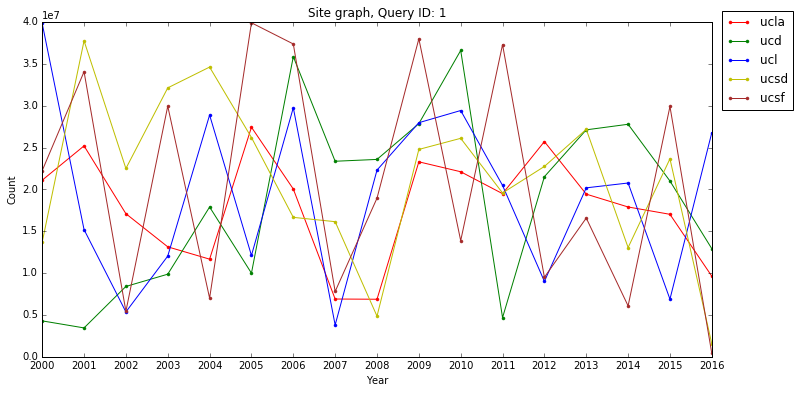

In [1]:

import csv
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets

filepath = "data/random-10000-data"
input_graph_queries = widgets.Text()
def handle_input_queries(sender):    
    queries_to_find = sender.value.split(",")
    for query_id in queries_to_find:
        filtered_queries = [] # 2D row.column
        header = []
        with open(filepath, "r") as f:
            reader = csv.reader(f)
            for row in reader:
                if not header:
                    header = row
                if row[0] == query_id:
                    filtered_queries.append([int(i) for i in row]);

        # Prepare graph values
        columns = [[] for i in header[1:]]
        for row in filtered_queries:
            for i, column in enumerate(row[1:]):
                columns[i].append(column)

        # Draw graph
        %matplotlib inline
        fig, ax = plt.subplots(figsize=(12, 6))
        bar_width = 0.35
        opacity = 0.4
        #print(columns)
        colors = ["r", "g", "b", "y", "brown"]
        for i, column in enumerate(columns[1:]): # Skip year
            #print(i, column)
            if 0:
                plt.bar(columns[0], column, bar_width,
                        color=colors[i],
                        label=header[i + 2]) # Skip year and query_id
            else:
                plt.errorbar(columns[0], column, color=colors[i], label=header[i + 2], fmt="b.-")

        plt.xlabel('Year')
        plt.ylabel('Count')
        plt.title('Site graph, Query ID: %s' % query_id)
        plt.xticks(columns[0])
        plt.legend(bbox_to_anchor=(1.13, 1.05))

        #plt.tight_layout()
        plt.show() # Used for new graph   
        
    
    
input_graph_queries.on_submit(handle_input_queries)
input_graph_queries

# Query id graphs

Use 'x-y' for range(end including) and 'x,y,z...' for list


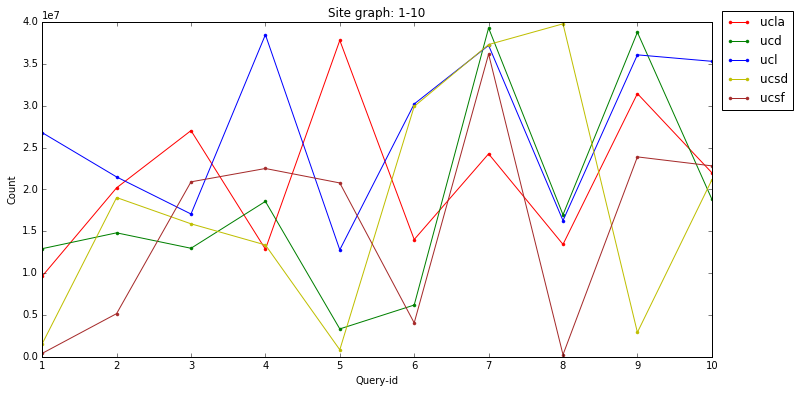

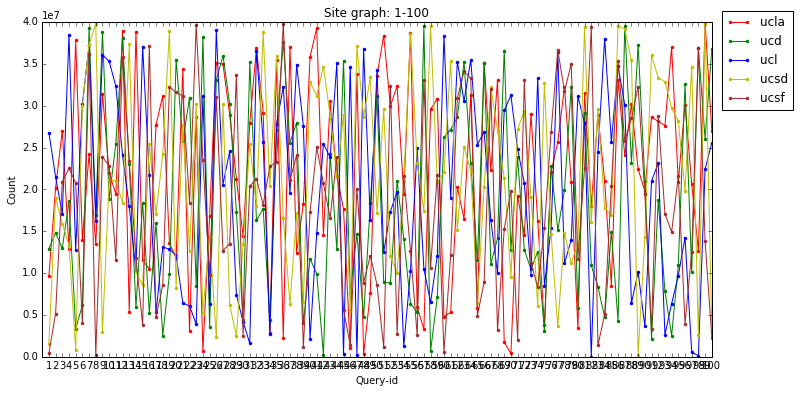

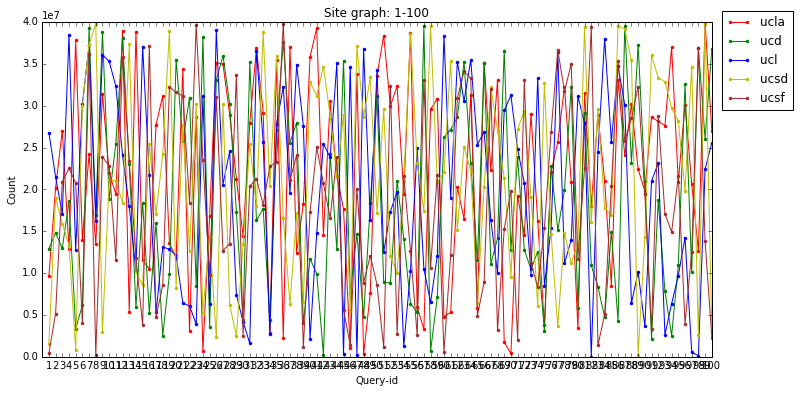

In [3]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets

filepath = "data/random-10000-data"
print("Use 'x-y' for range(end including) and 'x,y,z...' for list")
input_graph_queries = widgets.Text()
def handle_input_queries(sender):
    # Parse input range or list
    if("-" in sender.value):
        queries_to_find = sender.value.split("-")
        queries_to_find = [int(i) for i in queries_to_find]
        queries_to_find = [str(i) for i in range(queries_to_find[0], queries_to_find[1]+1)]
    else:
        queries_to_find = sender.value.split(",")
    
    # Filter queries from data
    filtered_queries = [] # 2D row.column
    header = []
    for query_id in queries_to_find:
        with open(filepath, "r") as f:
            reader = csv.reader(f)
            for row in reader:
                if not header:
                    header = row
                if row[0] == query_id and row[1] == "2016":
                    filtered_queries.append([int(i) for i in row]);

    # Translate row.column into column.row
    columns = [[] for i in header]
    for row in filtered_queries:
        for i, column in enumerate(row):
            columns[i].append(column)
    # Draw graph
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35
    opacity = 0.4
    #print(columns)
    colors = ["r", "g", "b", "y", "brown"]
    for i, column in enumerate(columns[2:]): # Skip query_id and year
        #print(i, column)
        if 0:
            plt.bar(columns[0], column, bar_width,
                    color=colors[i],
                    label=header[i + 2]) # Skip year and query_id
        else:
            plt.errorbar(columns[0], column, color=colors[i], label=header[i + 2], fmt="b.-")

    plt.xlabel('Query-id')
    plt.ylabel('Count')
    plt.title('Site graph: %s' % sender.value)
    plt.xticks(columns[0])
    plt.legend(bbox_to_anchor=(1.13, 1.05))

    #plt.tight_layout()
    plt.show() # Used for new graph   
        
    
input_graph_queries.on_submit(handle_input_queries)

input_graph_queries